<a href="https://colab.research.google.com/github/bdemchak/cytoscape-jupyter/blob/main/gangsu/basic_protocol_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a work-in-progress reproduction of the [Biological Network Exploration with Cytoscape 3](https://pubmed.ncbi.nlm.nih.gov/25199793/) Basic Protocol 2, which imports data from the Goh/Barabasi human disease network and displays it for exploration.


---
#Setup data files, py4cytoscape and Cytoscape connection
---
**NOTE: To run this notebook, you must manually start Cytoscape first -- don't proceed until you have started Cytoscape.**

---
##Setup: Import source data files

The network files are pre-positioned in GitHub, and are downloaded here for convenience. Once downloaded into the Python file system, they are downloaded into the Cytoscape sandbox for direct access by Cytoscape.

They really should be in web locations enables them to be downloaded directly by Cytoscape via a CyREST POST v1/networks call (assuming we can get Cytoscape itself to load directly from a URL). 


In [1]:
!rm -r Barabasi
!mkdir Barabasi
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/disease.net.txt -O Barabasi/disease.net.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/gene.net.txt -O Barabasi/gene.net.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS2.txt -O Barabasi/supplementary_tablesS2.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS3.txt -O Barabasi/supplementary_tablesS3.txt
!wget -q --no-check-certificate https://raw.githubusercontent.com/bdemchak/cytoscape-jupyter/main/gangsu/Barabasi/supplementary_tableS4.txt -O Barabasi/supplementary_tablesS4.txt

!rm -r output/
!mkdir output
!ls -l 
OUTPUT_DIR = 'output/'


total 16
drwxr-xr-x 2 root root 4096 Dec  5 23:40 Barabasi
drwxr-xr-x 2 root root 4096 Dec  5 19:06 logs
drwxr-xr-x 2 root root 4096 Dec  5 23:40 output
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data


---
##Setup: Fetch latest py4cytoscape




**Note that you can fetch from a specific github branch by adding "@<branch>" to the "py4cytocape" at the end of the github URL.**

For example, to get branch 0.0.5: git+https://github.com/cytoscape/py4cytoscape@0.0.5

In [2]:
!pip uninstall -y py4cytoscape

!pip install py4cytoscape
#!pip install git+https://github.com/cytoscape/py4cytoscape@0.0.5
#!pip install git+https://github.com/cytoscape/py4cytoscape

Uninstalling py4cytoscape-0.0.6:
  Successfully uninstalled py4cytoscape-0.0.6
  Using cached https://files.pythonhosted.org/packages/36/89/e3bf0ba869f99c5695a53fd540f259738aa8bd806c8741ab628fb64471ba/py4cytoscape-0.0.6-py3-none-any.whl


---
##Setup: Set up Cytoscape connection


In [3]:
import IPython
import py4cytoscape as p4c
print(f'Loading Javascript client ... {p4c.get_browser_client_channel()} on {p4c.get_jupyter_bridge_url()}')
browser_client_js = p4c.get_browser_client_js(True)
IPython.display.Javascript(browser_client_js) # Start browser client


Loading Javascript client ... 716a7b6f-696f-4084-a8f0-f175e7800be0 on https://jupyter-bridge.cytoscape.org


<IPython.core.display.Javascript object>

---
#Sanity test to verify Cytoscape connection


In [4]:
p4c.cytoscape_version_info()


{'apiVersion': 'v1',
 'automationAPIVersion': '1.0.0',
 'cytoscapeVersion': '3.8.2',
 'jupyterBridgeVersion': '0.0.2',
 'py4cytoscapeVersion': '0.0.6'}

---
# Position network files into Cytoscape's current sandbox

**Sandboxing is explained in https://py4cytoscape.readthedocs.io/en/latest/concepts.html#sandboxing**

In [11]:
sandbox = p4c.sandbox_get_file_info('.')['filePath']
sandbox


'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox'

In [16]:
p4c.sandbox_send_to('Barabasi/supplementary_tablesS2.txt')
p4c.sandbox_send_to('Barabasi/supplementary_tablesS3.txt')
p4c.sandbox_send_to('Barabasi/supplementary_tablesS4.txt')
p4c.sandbox_send_to('Barabasi/disease.net.txt')
p4c.sandbox_send_to('Barabasi/gene.net.txt')

{'filePath': 'C:\\Users\\CyDeveloper\\CytoscapeConfiguration\\filetransfer\\default_sandbox\\gene.net.txt'}

# Discover local gene clusters using MCODE

##Import the human protein-protein interactions network.

This could take a few minutes because of the automatic force-directed layout.

We would prefer to use import_network_from_file, but it doesn't allow any configuration of source/target/interaction/startrow/delimiter. We should fix this.

Note that as long as we're using commands_post, we can't take advantage of the encapsulation provided by sandboxes. Let's try to avoid this.


In [17]:
p4c.close_session(False)
p4c.commands_post(f'network import file file="{sandbox}/supplementary_tablesS4.txt" firstRowAsColumnNames=true startLoadRow=2 indexColumnSourceInteraction=2 indexColumnTargetInteraction=4 indexColumnTypeInteraction=5 columnTypeList="x,s,x,t,i"')


{'networks': [234434], 'views': [263992]}

##Layout and overlay information on the network

1.   Create a different colors for the edges representing different types of interactions.
2.   Make the nodes themselves transparent so edges are easier to see.
3.   For fun, create an image of the resulting network and display it in this notebook.


This file already exists. A Cytoscape popup will be generated to confirm overwrite.


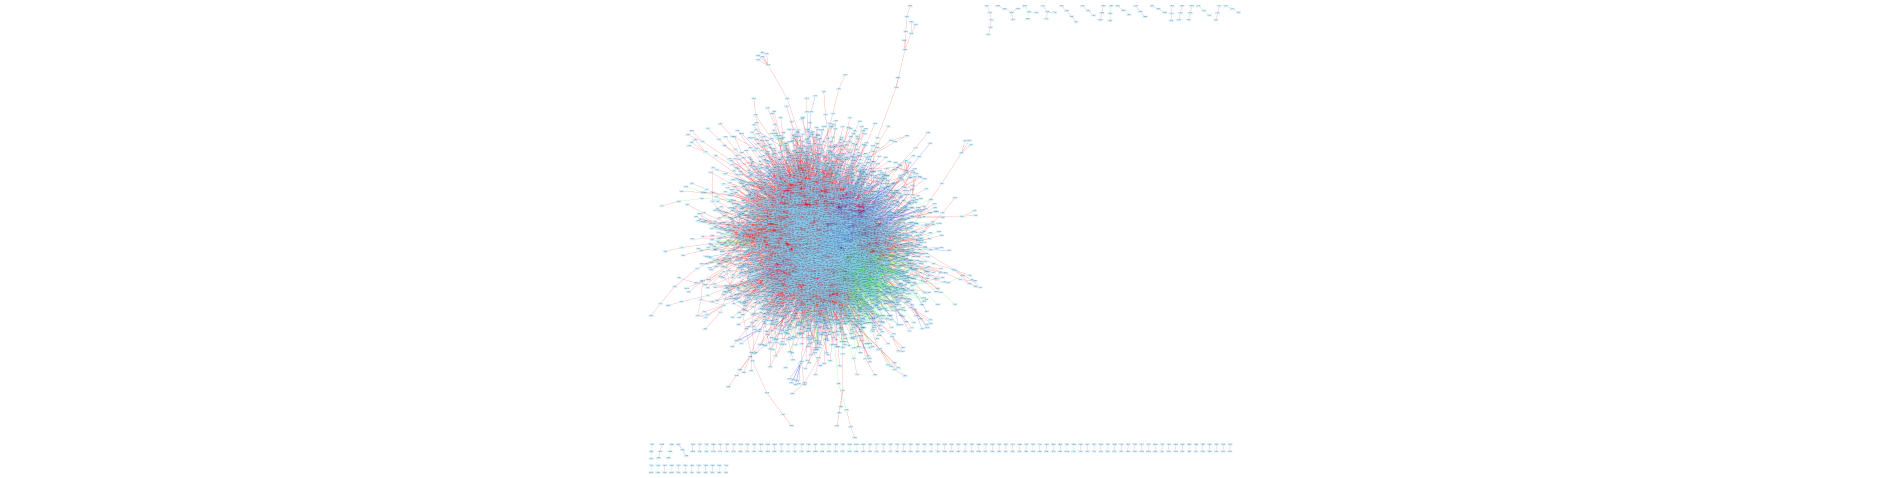

In [18]:
RED = '#ff0000'
GREEN = '#00ff00'
TEAL = '#00ffff'
PURPLE = '#ff00ff'
YELLOW = '#ffff00', 
BLUE = '#0000ff'
GREY = '#808080'

map = p4c.map_visual_property('EDGE_STROKE_UNSELECTED_PAINT', 'interaction', 'discrete', 
                              ['L', 'R', 'RL', 'RS', 'RSL', 'S', 'SL'], 
                              [RED, GREEN, TEAL, PURPLE, YELLOW, BLUE, GREY])
p4c.update_style_mapping('default', map)

p4c.set_node_fill_opacity_default(100, 'default')
p4c.toggle_graphics_details()

OUT_FILE = 'WholeNetwork.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))

{}
This file already exists. A Cytoscape popup will be generated to confirm overwrite.


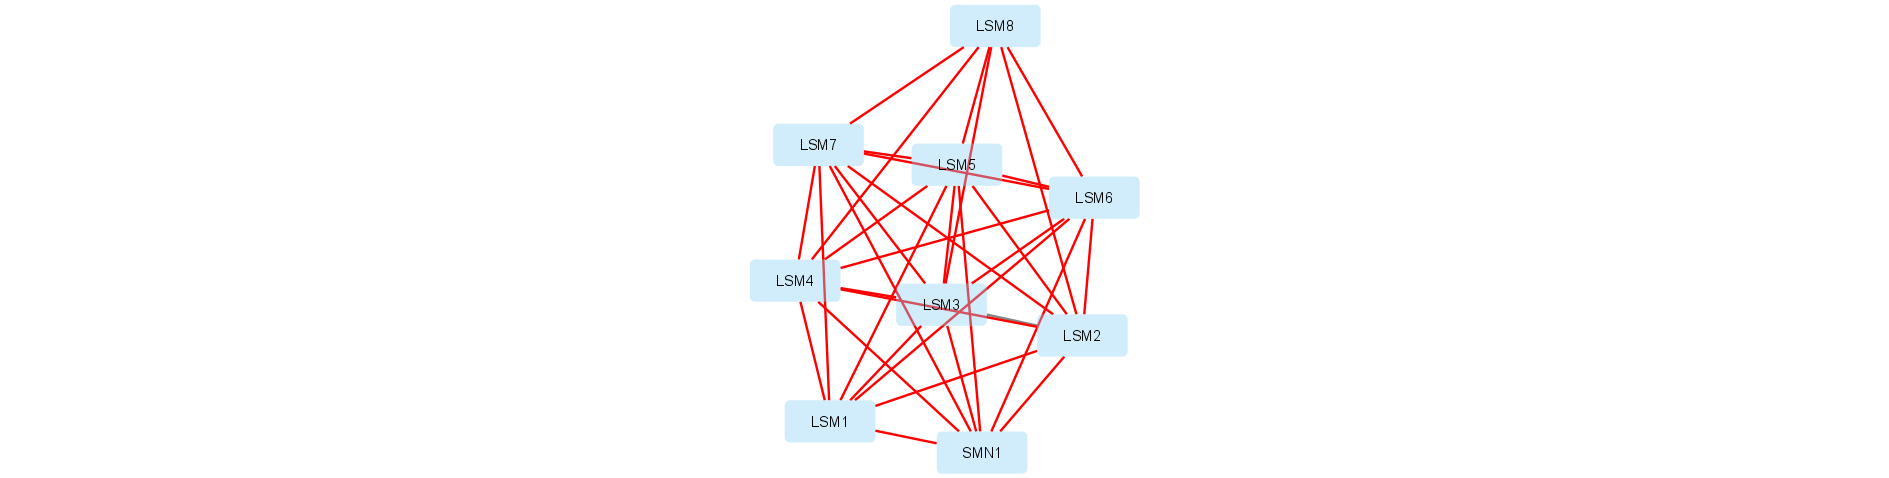

In [19]:
p4c.install_app('MCODE')
p4c.commands_post('mcode cluster network=""')
p4c.commands.commands_post('mcode view id=1 rank=2')

OUT_FILE = 'Cluster.png'
p4c.export_image(OUT_FILE)
p4c.sandbox_get_from(OUT_FILE, f'{OUTPUT_DIR}{OUT_FILE}')

from IPython.display import Image, display
display(Image(filename=f'{OUTPUT_DIR}{OUT_FILE}'))